In [92]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:

import numpy
import time
import random
import os
import multiprocessing

from pysted import base, utils, raster, bleach_funcs, temporal, microscopes
from matplotlib import pyplot
from tqdm.auto import trange
from scipy import optimize

numpy.random.seed(42)
random.seed(42)

# molecules_disposition = (numpy.random.rand(40, 40) > 0.9).astype(int) * 10
delta = 1
num_mol = 2
molecules_disposition = numpy.zeros((50, 50))
# molecules_disposition[
#     molecules_disposition.shape[0]//2 - delta : molecules_disposition.shape[0]//2+delta + 1,
#     molecules_disposition.shape[1]//2 - delta : molecules_disposition.shape[1]//2+delta + 1] = num_mol
for j in range(1,4):
    for i in range(1,4):
#         molecules_disposition[
#             i * molecules_disposition.shape[0]//4,
#             j * molecules_disposition.shape[1]//4] = num_mol
        molecules_disposition[
            j * molecules_disposition.shape[0]//4 - delta : j * molecules_disposition.shape[0]//4 + delta + 1,
            i * molecules_disposition.shape[1]//4 - delta : i * molecules_disposition.shape[1]//4 + delta + 1] = num_mol

egfp = {"lambda_": 535e-9,
        "qy": 0.6,
        "sigma_abs": {488: 3e-20,
                      575: 6e-21},
        "sigma_ste": {560: 1.2e-20,
                      575: 6.0e-21,
                      580: 5.0e-21},
        "sigma_tri": 1e-21,
        "tau": 3e-09,
        "tau_vib": 1.0e-12,
        "tau_tri": 5e-6,
        "phy_react": {488: 0.25e-7,   # 1e-4
                      575: 1e-11},   # 1e-8
        "k_isc": 0.26e6}
pixelsize = 20e-9
bleach = True
p_ex = 2e-6
p_ex_array = numpy.ones(molecules_disposition.shape) * p_ex
p_sted = 2.5e-3
p_sted_array = numpy.ones(molecules_disposition.shape) * p_sted
pdt = 100e-6
pdt_array = numpy.ones(molecules_disposition.shape) * pdt
roi = 'max'

params = {
    "pdt":pdt, 
    "p_ex":p_ex, 
    "p_sted":p_sted
}

num_acquisition = 25

# Generating objects necessary for acquisition simulation
laser_ex = base.GaussianBeam(488e-9)
laser_sted = base.DonutBeam(575e-9, zero_residual=0)
detector = base.Detector(noise=True, background=0)
objective = base.Objective()
fluo = base.Fluorescence(**egfp)

In [95]:

def acquire_all(experiment, num_acquisition, bleach=True, processes=0):
    """
    Acquires from all microsopes

    :param num_acquisition: An `int` of the number of acquired frames
    :param bleach: A `bool` whether to bleach the sample
    :param processes: An `int` of the number of processes to use in `multiprocessing`

    :returns : A `dict` of the history for each microscope
    """
    history = {}
    if processes:
        def log_callback(data):
            name, hist = data
            history[name] = hist
        pool = multiprocessing.Pool(processes=processes)
        calls = [pool.apply_async(experiment.acquire, kwds={"name":name, "num_acquisition":num_acquisition, "bleach":bleach, "verbose":True}, callback=log_callback)
                    for name in experiment.microscopes.keys()]
        pool.close()
        pool.join()
        for c in calls: c.get()
    else:
        for name in experiment.microscopes.keys():
            name, out = experiment.acquire(name=name, num_acquisition=num_acquisition, bleach=bleach)
            history[name] = out
    return history    
    
def get_resolution(emitter, delta=8):
    def gaussian(x,a,x0,sigma):
        return a*numpy.exp(-(x-x0)**2/(2*sigma**2))
    x, y = numpy.arange(emitter.shape[1]) - emitter.shape[1]//2, emitter[:, emitter.shape[1] // 2 - 2 : emitter.shape[1] // 2 + 2].mean(axis=-1)
    center = len(x) // 2
    x = x[center - delta : center + delta]
    y = y[center - delta : center + delta]
    try:
        popt, pcov = optimize.curve_fit(gaussian, x, y, bounds=((-numpy.inf, -numpy.inf, 0), numpy.inf))
    except RuntimeError:
        return 0.
#     fig, ax = pyplot.subplots()
#     ax.plot(x, y)
#     ax.plot(x, gaussian(x, *popt))
#     pyplot.show()    
    return 2 * numpy.sqrt(2 * numpy.log(2)) * popt[-1] * pixelsize * 1e+9

def plot_and_gen_gif(histories, savename=None, keys=None, show_res=False):
    from PIL import Image
    def roundint(x, val=10):
        return round(x / val) * val
    def gen_frame(path):
        im = Image.open(path)
        alpha = im.getchannel('A')

        # Convert the image into P mode but only use 255 colors in the palette out of 256
        im = im.convert('RGB').convert('P', palette=Image.ADAPTIVE, colors=255)

        # Set all pixel values below 128 to 255 , and the rest to 0
        mask = Image.eval(alpha, lambda a: 255 if a <=128 else 0)

        # Paste the color of index 255 and use alpha as a mask
        im.paste(255, mask)

        # The transparency index is 255
        im.info['transparency'] = 255

        return im        
    
    filenames = []
    if isinstance(keys, type(None)):
        keys = list(sorted(histories.keys()))
    maxvalues = [roundint(histories[key]["acquisition"][0].max()) for key in keys]
    print([(key, roundint(histories[key]["acquisition"][0].max())) for key in keys])
    for i in range(histories[keys[0]]["datamap"].shape[0]):
    
        fig, axes = pyplot.subplots(len(keys), 3, figsize=(5, len(keys)+1), sharex=True, sharey=True)
#         fig, axes = pyplot.subplots(len(keys), 3, figsize=(10, 5))
        for n, key in enumerate(keys):
            axes[n, 0].imshow(histories[key]["datamap"][i], vmin=0, vmax=histories[key]["datamap"][0].max(), cmap="gray")
            if key == "STED":
                axes[n, 1].imshow(numpy.ones_like(histories[key]["other"][i]), vmin=0, vmax=1, cmap="Blues")
            else:
                axes[n, 1].imshow(histories[key]["other"][i], vmin=0, vmax=1, cmap="Blues")        
            axes[n, 2].imshow(histories[key]["acquisition"][i], vmin=0, vmax=max(maxvalues), cmap="hot")
            if show_res:
                axes[n, 2].set_title("{:0.1f} nm".format(get_resolution(histories[key]["acquisition"][i])))
            axes[n, 0].set(
                ylabel=key
            )
        axes[0, 0].set(
            title=f"Frame {i}"
        )
        for ax in axes.ravel():
            pyplot.setp(ax.get_xticklabels(), visible=False)
            pyplot.setp(ax.get_yticklabels(), visible=False)
            ax.tick_params(axis='both', which='both', length=0)

        if savename:
            filename = f"./panels/frame{i}.png"
            fig.savefig(filename, transparent=True, bbox_inches="tight", dpi=300)
            pyplot.close("all")
            filenames.append(filename)
    
    if savename:
        image = gen_frame(filenames[0])
        append_images = []
        for filename in filenames[1:]:
            append_images.append(gen_frame(filename))
        image.save(savename, save_all=True, append_images=append_images, loop=0, duration=400, disposal=2, optimize=False)
        for filename in filenames:
            os.remove(filename)

def plot_bleaching_curve(histories, savename=None, keys=None):
    """
    Utilitary function to plot the normalized average number of molecules per frame
    
    :param histories: A `dict` of the history
    :param savename: (optional) A `str` of the savepath
    :param keys: (optional): A `list` of keys to access in the histories
    """
    fig, ax = pyplot.subplots(figsize=(3, 3), tight_layout=True)
    if isinstance(keys, type(None)):
        keys = list(sorted(histories.keys()))
    for key in keys:
        init_mol = histories[key]["datamap"][0, molecules_disposition != 0].mean(axis=-1)
        molecules = histories[key]["datamap"][:, molecules_disposition != 0].mean(axis=-1) / init_mol
        ax.plot(molecules, label=key)
    ax.set(
        ylabel="Avg. molecules left", xlabel="Frames"
    )
    ax.legend()
    if isinstance(savename, str):
        fig.savefig(savename, transparent=True, bbox_inches="tight")
        pyplot.close("all")
    else:
        pyplot.show()

# Compare DyMIN and Conventional

In [96]:
experiment = utils.Experiment()

# Create the DyMIN microscope
opts = {
    "scale_power" : [0., 0.25, 1.],
    "decision_time" : [10e-6, 10e-6, -1],
    "threshold_count" : [8, 8, 0]
}
datamap = base.Datamap(molecules_disposition, pixelsize)
microscope = microscopes.DyMINMicroscope(laser_ex, laser_sted, detector, objective, fluo, opts=opts)
i_ex, _, _ = microscope.cache(datamap.pixelsize, save_cache=True)
datamap.set_roi(i_ex, roi)
experiment.add("DyMIN", microscope, datamap, params=params)

# Create the STED microscope
datamap = base.Datamap(molecules_disposition, pixelsize)
microscope = base.Microscope(laser_ex, laser_sted, detector, objective, fluo)
i_ex, _, _ = microscope.cache(datamap.pixelsize, save_cache=True)
datamap.set_roi(i_ex, roi)
experiment.add("STED", microscope, datamap, params=params)

In [97]:
histories = acquire_all(experiment, num_acquisition, bleach=True, processes=2)

[('DyMIN', 170), ('STED', 150)]


<ipython-input-95-159a30b366a7>:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pyplot.subplots(len(keys), 3, figsize=(5, len(keys)+1), sharex=True, sharey=True)


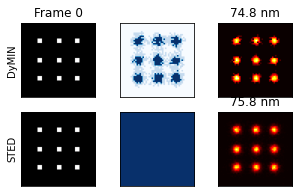

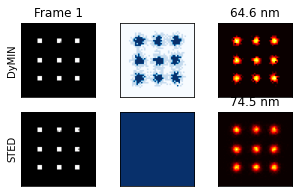

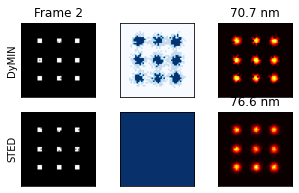

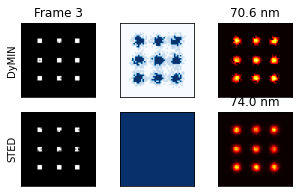

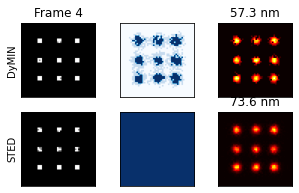

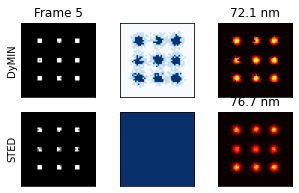

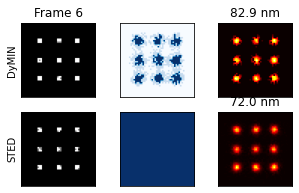

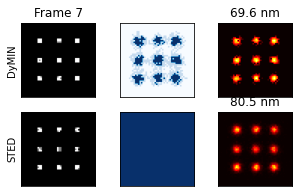

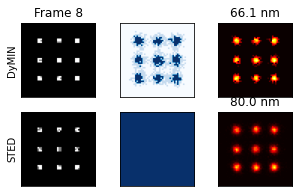

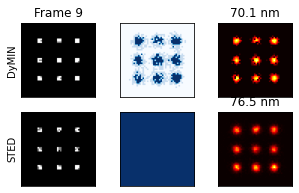

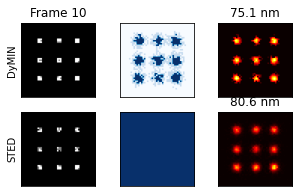

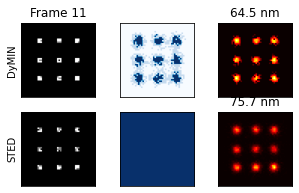

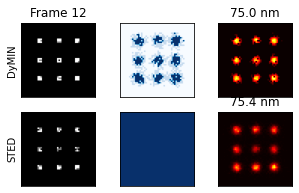

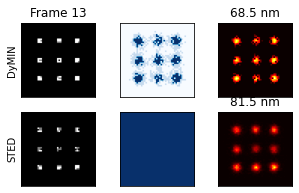

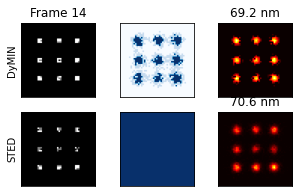

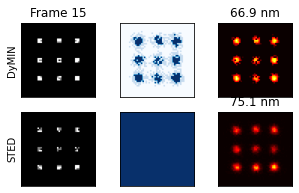

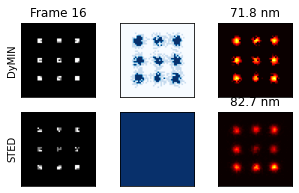

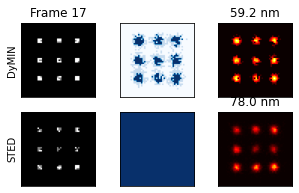

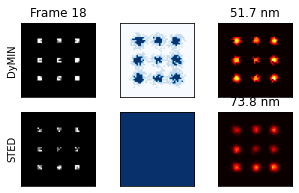

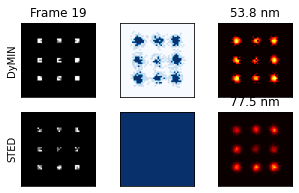

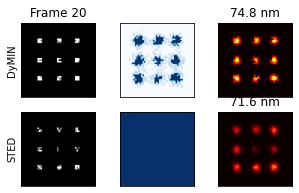

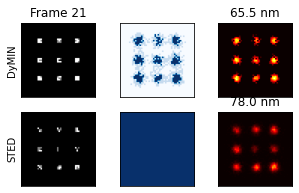

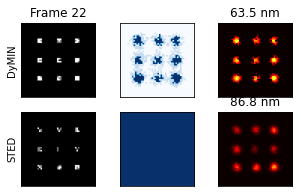

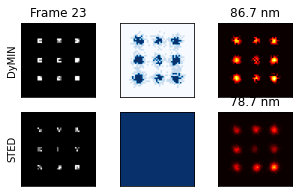

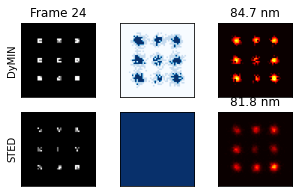

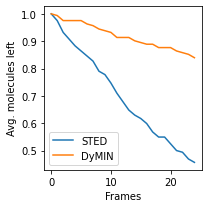

In [98]:
plot_and_gen_gif(histories, show_res=True)
plot_bleaching_curve(histories, keys=["STED", "DyMIN"])
# plot_and_gen_gif(histories, show_res=True, savename="./panels/image_dymin-conventional_multiplesources-wnoise.gif")
# plot_bleaching_curve(histories, keys=["STED", "DyMIN"], savename="./panels/bleachingcurve_dymin-conventional_multiplesources-wnoise.pdf")

# Compare reducing number of molecules

In [36]:
experiment = utils.Experiment()

for num_mol in range(2, 12, 4):
    molecules_disposition = numpy.zeros((50, 50))
    for i in range(1,4):
        for j in range(1,4):
            molecules_disposition[
                i * molecules_disposition.shape[0]//4,
                j * molecules_disposition.shape[1]//4] = num_mol
            
    # Create the DyMIN microscope
    opts = {
        "scale_power" : [0., 0.25, 1.],
        "decision_time" : [10e-6, 10e-6, -1],
        "threshold_count" : [10, 5, 0]    
    }
    datamap = base.Datamap(molecules_disposition, pixelsize)
    microscope = microscopes.DyMINMicroscope(laser_ex, laser_sted, detector, objective, fluo, opts=opts)
    i_ex, _, _ = microscope.cache(datamap.pixelsize, save_cache=True)
    datamap.set_roi(i_ex, roi)
    experiment.add("DyMIN-{:02d}".format(num_mol), microscope, datamap, params=params)

In [37]:
histories = acquire_all(experiment, 1, bleach=False, processes=4)

In [42]:
plot_and_gen_gif(histories, show_res=True, savename="./panels/compare_dymin-number-molecules_multiplesources.gif")

[('DyMIN-02', 0), ('DyMIN-06', 0), ('DyMIN-10', 120)]


# Compare different structures

## Multiple point sources

In [ ]:
# Creates a new molecule disposition
numpy.random.seed(42)
random.seed(42)

# p_ex = 1e-6
# p_ex_array = numpy.ones(molecules_disposition.shape) * p_ex
# p_sted = 2.5e-3
# p_sted_array = numpy.ones(molecules_disposition.shape) * p_sted
# pdt = 100e-6
# pdt_array = numpy.ones(molecules_disposition.shape) * pdt

molecules_disposition = (numpy.random.rand(50, 50) > 0.99).astype(int) * 16

experiment = utils.Experiment()

opts = {
    "scale_power" : [0., 0.25, 1.],
    "decision_time" : [10e-6, 10e-6, None],
    "threshold_count" : [2, 2, 0]    
}
datamap = base.Datamap(molecules_disposition, pixelsize)
microscope = microscopes.DyMINMicroscope(laser_ex, laser_sted, detector, objective, fluo, opts=opts)
i_ex, _, _ = microscope.cache(datamap.pixelsize, save_cache=True)
datamap.set_roi(i_ex, roi)
experiment.add("DyMIN", microscope, datamap)

datamap = base.Datamap(molecules_disposition, pixelsize)
microscope = base.Microscope(laser_ex, laser_sted, detector, objective, fluo)
i_ex, _, _ = microscope.cache(datamap.pixelsize, save_cache=True)
datamap.set_roi(i_ex, roi)
experiment.add("STED", microscope, datamap)

In [ ]:
histories = experiment.acquire_all(num_acquisition=2, processes=2, bleach=True)

In [ ]:
%matplotlib inline
# plot_and_gen_gif(histories, savename="./panels/compare_dymin-conventional_default-structure.gif")
plot_and_gen_gif(histories, show_res=False)

fig, ax = pyplot.subplots(figsize=(3, 3), tight_layout=True)
for key in ["STED", "DyMIN"]:
    molecules = histories[key]["datamap"][:, molecules_disposition != 0].mean(axis=-1)
    ax.plot(molecules, label=key)
ax.set(
    ylabel="Avg. molecules left", xlabel="Frames"
)
ax.legend()
# fig.savefig("./panels/molecules-structure_evolution.pdf", transparent=True, bbox_inches="tight")
pyplot.show()

## Fiber-like structure

Objects:   0%|          | 0/10 [00:00<?, ?it/s]

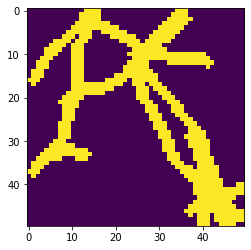

In [83]:
from skimage import morphology
# Creates a new molecule disposition
numpy.random.seed(42)
random.seed(42)

image = numpy.zeros((50, 50))
ensemble = temporal.Ensemble(roi=((0, 0), image.shape))
for _ in trange(10, desc="Objects", leave=False):
    obj = temporal.Fiber(random_params={
        "num_points" : (30, 50),
        "pos" : [(0, 0), image.shape]
    })
    ensemble.append(obj)
molecules_disposition = ensemble.return_frame() > 0
molecules_disposition = morphology.binary_dilation(molecules_disposition)
molecules_disposition[molecules_disposition != 0] = 2

fig, ax = pyplot.subplots()
ax.imshow(molecules_disposition)
pyplot.show()

experiment = utils.Experiment()

opts = {
    "scale_power" : [0., 0.25, 1.],
    "decision_time" : [10e-6, 10e-6, -1],
    "threshold_count" : [8, 8, 0]    
}
datamap = base.Datamap(molecules_disposition, pixelsize)
microscope = microscopes.DyMINMicroscope(laser_ex, laser_sted, detector, objective, fluo, opts=opts)
i_ex, _, _ = microscope.cache(datamap.pixelsize, save_cache=True)
datamap.set_roi(i_ex, roi)
experiment.add("DyMIN", microscope, datamap, params=params)

datamap = base.Datamap(molecules_disposition, pixelsize)
microscope = base.Microscope(laser_ex, laser_sted, detector, objective, fluo)
i_ex, _, _ = microscope.cache(datamap.pixelsize, save_cache=True)
datamap.set_roi(i_ex, roi)
experiment.add("STED", microscope, datamap, params=params)

In [84]:
histories = acquire_all(experiment, num_acquisition=num_acquisition, processes=2, bleach=True)

In [85]:
plot_and_gen_gif(histories, savename="./panels/compare_dymin-conventional_fiber-structure.gif")
plot_bleaching_curve(histories, keys=["STED", "DyMIN"], savename="./panels/bleachingcurve_dymin-conventional_fiber-structure.pdf")

[('DyMIN', 180), ('STED', 150)]


# Compare DyMIN parameters

In [45]:
# Creates a new molecule disposition
numpy.random.seed(42)
random.seed(42)

delta = 1
num_mol = 2
molecules_disposition = numpy.zeros((50, 50))
# molecules_disposition[
#     molecules_disposition.shape[0]//2 - delta : molecules_disposition.shape[0]//2+delta + 1,
#     molecules_disposition.shape[1]//2 - delta : molecules_disposition.shape[1]//2+delta + 1] = num_mol
for j in range(1,4):
    for i in range(1,4):
#         molecules_disposition[
#             i * molecules_disposition.shape[0]//4,
#             j * molecules_disposition.shape[1]//4] = num_mol
        molecules_disposition[
            j * molecules_disposition.shape[0]//4 - delta : j * molecules_disposition.shape[0]//4 + delta + 1,
            i * molecules_disposition.shape[1]//4 - delta : i * molecules_disposition.shape[1]//4 + delta + 1] = num_mol

experiment = utils.Experiment()

opts = {
    "scale_power" : [0., 0.25, 1.],
    "decision_time" : [10e-6, 10e-6, -1],
    "threshold_count" : [20, 10, 0]
}
datamap = base.Datamap(molecules_disposition, pixelsize)
microscope = microscopes.DyMINMicroscope(laser_ex, laser_sted, detector, objective, fluo, opts)
i_ex, _, _ = microscope.cache(datamap.pixelsize, save_cache=True)
datamap.set_roi(i_ex, roi)
experiment.add("tc20-10", microscope, datamap, params=params)


opts = {
    "scale_power" : [0., 0.25, 1.],
    "decision_time" : [10e-6, 10e-6, -1],
    "threshold_count" : [10, 5, 0]
}
datamap = base.Datamap(molecules_disposition, pixelsize)
microscope = microscopes.DyMINMicroscope(laser_ex, laser_sted, detector, objective, fluo, opts)
i_ex, _, _ = microscope.cache(datamap.pixelsize, save_cache=True)
datamap.set_roi(i_ex, roi)
experiment.add("tc10-5", microscope, datamap, params=params)

opts = {
    "scale_power" : [0., 0.25, 1.],
    "decision_time" : [10e-6, 10e-6, -1],
    "threshold_count" : [5, 2, 0]
}
datamap = base.Datamap(molecules_disposition, pixelsize)
microscope = microscopes.DyMINMicroscope(laser_ex, laser_sted, detector, objective, fluo, opts)
i_ex, _, _ = microscope.cache(datamap.pixelsize, save_cache=True)
datamap.set_roi(i_ex, roi)
experiment.add("tc5-2", microscope, datamap, params=params)

opts = {
    "scale_power" : [0., 0.25, 1.],
    "decision_time" : [10e-6, 10e-6, -1],
    "threshold_count" : [1, 1, 0]
}
datamap = base.Datamap(molecules_disposition, pixelsize)
microscope = microscopes.DyMINMicroscope(laser_ex, laser_sted, detector, objective, fluo, opts)
i_ex, _, _ = microscope.cache(datamap.pixelsize, save_cache=True)
datamap.set_roi(i_ex, roi)
experiment.add("tc1-1", microscope, datamap, params=params)

In [46]:
histories = acquire_all(experiment, num_acquisition=25, processes=4, bleach=True)

In [51]:
plot_and_gen_gif(histories, savename="./panels/compare_dymin-parameters_multiplesources.gif", keys=["tc20-10", "tc10-5", "tc5-2", "tc1-1"])
plot_bleaching_curve(histories, savename="./panels/bleachcurve_dymin-parameters_multiplesources.pdf", keys=["tc20-10", "tc10-5", "tc5-2", "tc1-1"])

# Increased intensity

In [ ]:
# Microscope stuff
egfp = {"lambda_": 535e-9,
        "qy": 0.6,
        "sigma_abs": {488: 1.15e-20,
                      575: 6e-21},
        "sigma_ste": {560: 1.2e-20,
                      575: 6.0e-21,
                      580: 5.0e-21},
        "sigma_tri": 1e-21,
        "tau": 3e-09,
        "tau_vib": 1.0e-12,
        "tau_tri": 5e-6,
        "phy_react": {488: 1e-7,   # 1e-4
                      575: 1e-11},   # 1e-8
        "k_isc": 0.26e6}
pixelsize = 10e-9
bleach = True
p_ex = 1e-6
p_ex_array = numpy.ones(molecules_disposition.shape) * p_ex
p_sted = 30e-3
p_sted_array = numpy.ones(molecules_disposition.shape) * p_sted
pdt = 100e-6
pdt_array = numpy.ones(molecules_disposition.shape) * pdt
roi = 'max'

# Generating objects necessary for acquisition simulation
laser_ex = base.GaussianBeam(488e-9)
laser_sted = base.DonutBeam(575e-9, zero_residual=0)
detector = base.Detector(noise=True, background=0)
objective = base.Objective()
fluo = base.Fluorescence(**egfp)

experiment = Experiment()

opts = {
    "scale_power" : [0., 0.25, 1.],
    "decision_time" : [10e-6, 10e-6, None],
    "threshold_count" : [10, 5, 0]
}
datamap = base.Datamap(molecules_disposition, pixelsize)
microscope = microscopes.DyMINMicroscope(laser_ex, laser_sted, detector, objective, fluo, opts)
i_ex, _, _ = microscope.cache(datamap.pixelsize, save_cache=True)
datamap.set_roi(i_ex, roi)
experiment.add("DyMIN", microscope, datamap)

datamap = base.Datamap(molecules_disposition, pixelsize)
microscope = base.Microscope(laser_ex, laser_sted, detector, objective, fluo)
i_ex, _, _ = microscope.cache(datamap.pixelsize, save_cache=True)
datamap.set_roi(i_ex, roi)
experiment.add("STED", microscope, datamap)

In [ ]:
histories = experiment.acquire_all(num_acquisition=2, bleach=True, processes=2)

In [ ]:
plot_and_gen_gif(histories)

In [ ]:
image = numpy.random.rand(4,5)
print(image)
fig, ax = pyplot.subplots()
ax.imshow(image)
pyplot.show()